# Introduction

**Active Learning** is a framework to overcome the problem of costly labels to train a supervised model. It uses the model to sample for the most informative samples for labelling so that accuracy can be obtained using few labels, compared to passive random sampling.

**ModAL** is a popular package written to test and implement active learning easily. https://modal-python.readthedocs.io/en/latest/

A **Literature Survey** written by Burr Settles, called "Active Learning Literature Survey" is an excellent resource for reference.


In [19]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

from sklearn.ensemble import RandomForestClassifier

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import margin_sampling
from modAL.uncertainty import entropy_sampling

# include custom function, random sampling for comparison
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return np.array([query_idx]), X_pool[query_idx]

import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# Functions

In [39]:
def active_learn(X, y, method, model, epoch, train_size, test_size):
    '''
    Active Learning using ModAL
    
    Parameters
    ----------
    X : np array
        features
    y : np array
        labels
    method : function
        sampling query method, called from modAL.uncertainty or custom function
    epoch : int
        number of model iterations
    train_size : int/float
        if int, absolute number
        if float, fraction of sample
    test_size : int/float
        if int, absolute number
        if float, fraction of sample
    
    Returns
    -------
    score_list : list of floats
        accuracy scores
    '''
    
    # split dataset into train, test, remain (simulated unlabelled) pools
    X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    X_remain, X_train, y_remain, y_train = train_test_split(X_pool, y_pool, test_size=train_size, random_state=0)
    
    learner = ActiveLearner(estimator=model,
                            query_strategy=method,
                            X_training=X_train, y_training=y_train)

    score_list=[]
    for i in range(epoch):
        query_idx, query_instance = learner.query(X_remain)
        learner.teach(X_remain[query_idx], y_remain[query_idx])
        score = learner.score(X_test, y_test)
        score_list.append(score)
        X_remain, y_remain = np.delete(X_remain, query_idx, axis=0), np.delete(y_remain, query_idx)

    return score_list



def run_exp1(X, y, method, samples, train_size, test_size):
    '''
    Active Learning experiment between 3 models, using least confident & random sampling
    '''
    
    randomforest = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1)

    method = uncertainty_sampling
    rf_al = active_learn(X, y, method, randomforest, samples, train_size, test_size)

    method = random_sampling
    rf_rand = active_learn(X, y, method, randomforest, samples, train_size, test_size)

    return rf_al, rf_rand



def run_exp3(X, y, method, samples, train_size, test_size):
    '''
    Active Learning experiment between least confident, margin, entropy and random sampling
    '''
    
    randomforest = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1)

    method = uncertainty_sampling
    rf_al = active_learn(X, y, method, randomforest, samples, train_size, test_size)
    method = margin_sampling
    rf_margin = active_learn(X, y, method, randomforest, samples, train_size, test_size)
    method = entropy_sampling
    rf_entropy = active_learn(X, y, method, randomforest, samples, train_size, test_size)
    method = random_sampling
    rf_rand = active_learn(X, y, method, randomforest, samples, train_size, test_size)
    
    return rf_al, rf_margin, rf_entropy, rf_rand


# Experiments

## All Features

 * We can tell that active sampling can retrain the model to a higher accuracy with fewer labels compared to random sampling

CPU times: user 5min 15s, sys: 1min 31s, total: 6min 46s
Wall time: 8min


Text(0.5, 1.0, 'Digits, Least Certain vs Random Sampling')

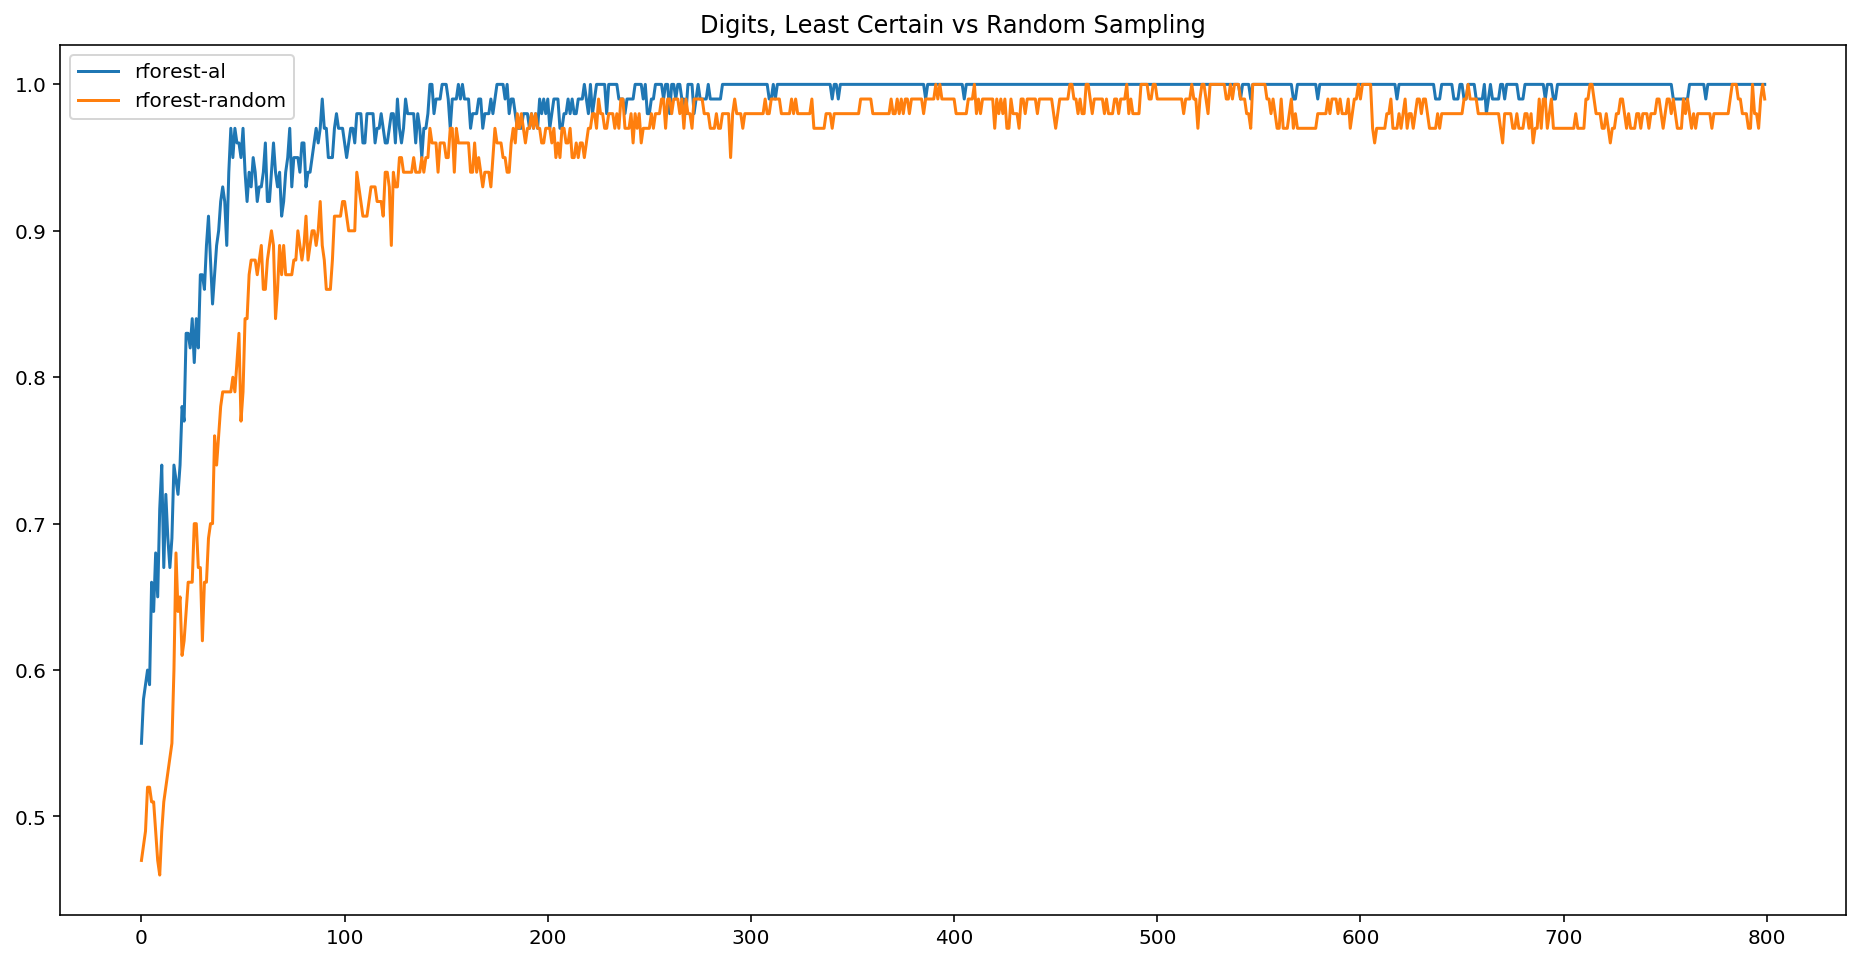

In [42]:
%%time

# load dataset
dataset = load_digits()
X = dataset.data
y = dataset.target

# run active sampling experiment 1
all_ =  run_exp1(X, y, uncertainty_sampling, 800, 20, 100)

# plot graph
plt.figure(figsize=(16,8))
for scores in all_:
    plt.plot(scores);
plt.legend(labels=['rforest-al','rforest-random']);
plt.title('Digits, Least Certain vs Random Sampling');

## Comparing with Less Features

 * In the real-world, data is not perfect
 * We might not have all the features required (think IOT sensors), hence active learning results can be affected
 * We can see from this instance that active learning is only marginally better than random sampling

CPU times: user 4min 52s, sys: 1min 45s, total: 6min 37s
Wall time: 8min 3s


Text(0.5, 1.0, 'Digits, Less Features')

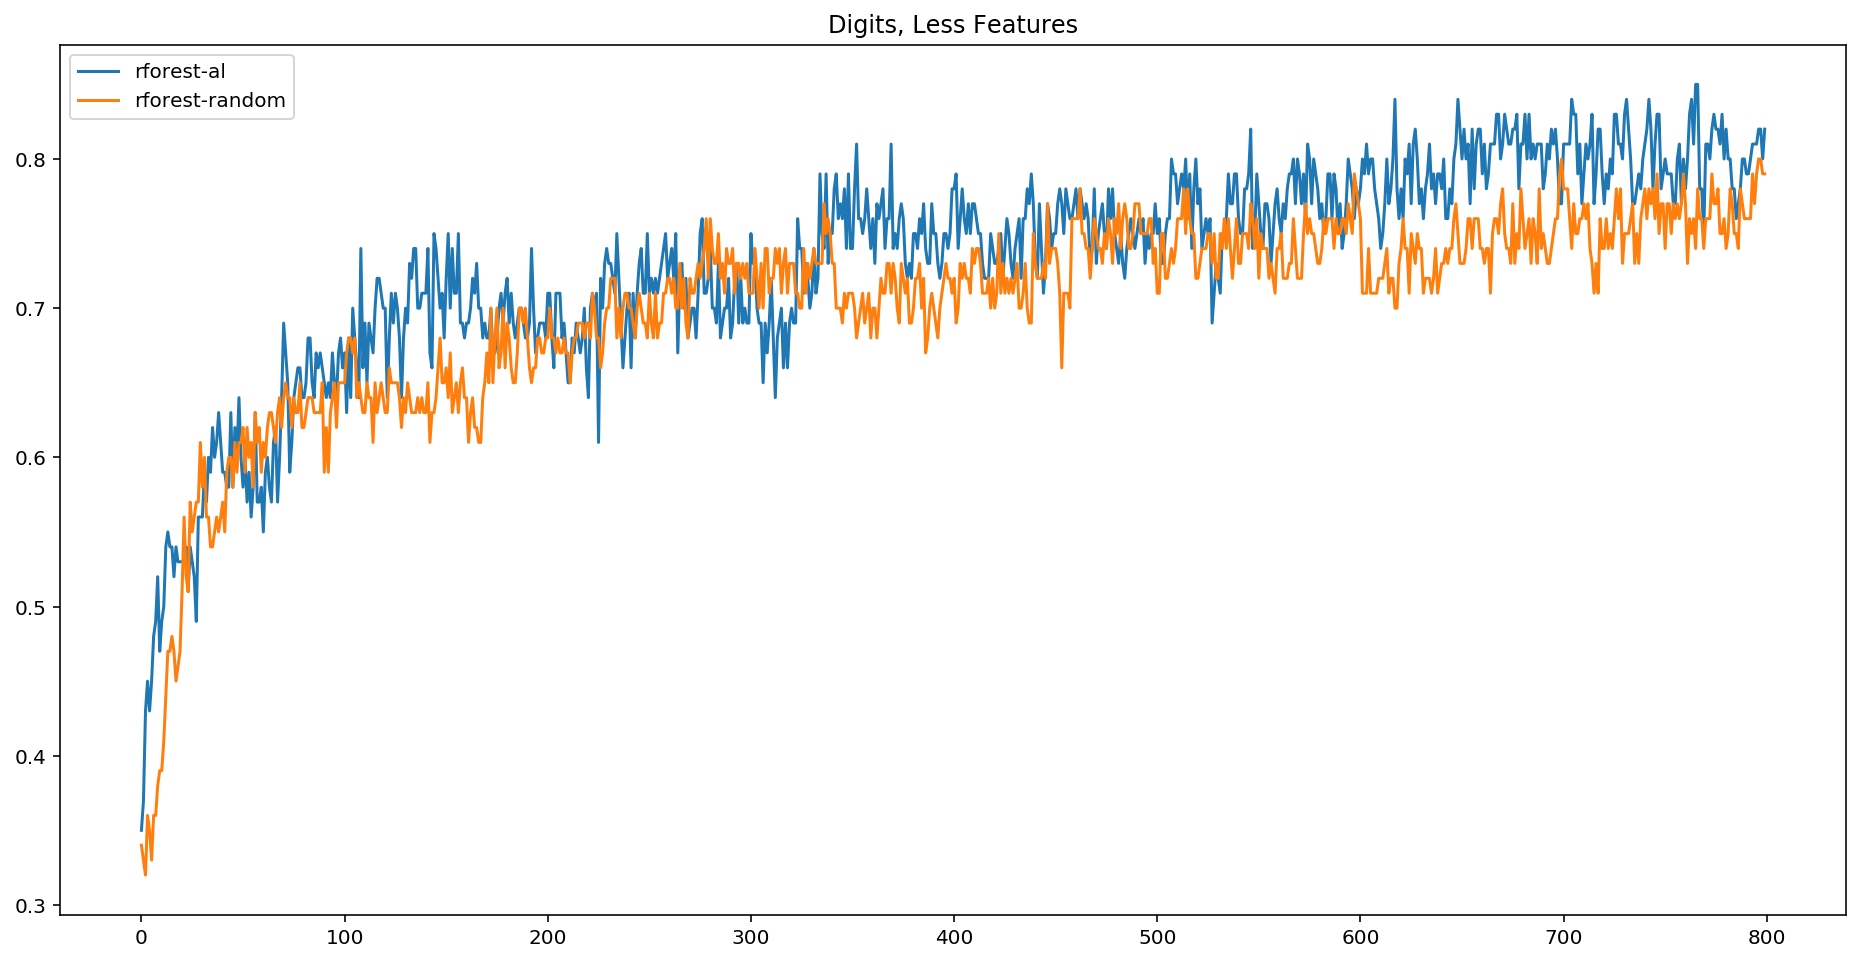

In [43]:
%%time

# load dataset
dataset = load_digits()
X = dataset.data[:,:-40] # remove 40 features
y = dataset.target

# run active sampling experiment 2
all_ =  run_exp1(X, y, uncertainty_sampling, 800, 20, 100)

# plot graph
plt.figure(figsize=(16,8))
for scores in all_:
    plt.plot(scores);
plt.legend(labels=['rforest-al','rforest-random']);
plt.title('Digits, Less Features');

## Comparing Between Sampling Methods

 * Uncertainity samping is the one of the query strategies used in active learning
 * It consists of 3 variants: uncertainity sampling, margin sampling and entropy sampling

CPU times: user 11min 24s, sys: 3min 16s, total: 14min 40s
Wall time: 18min 4s


Text(0.5, 1.0, 'Digits, Uncertainty Sampling Types Comparison')

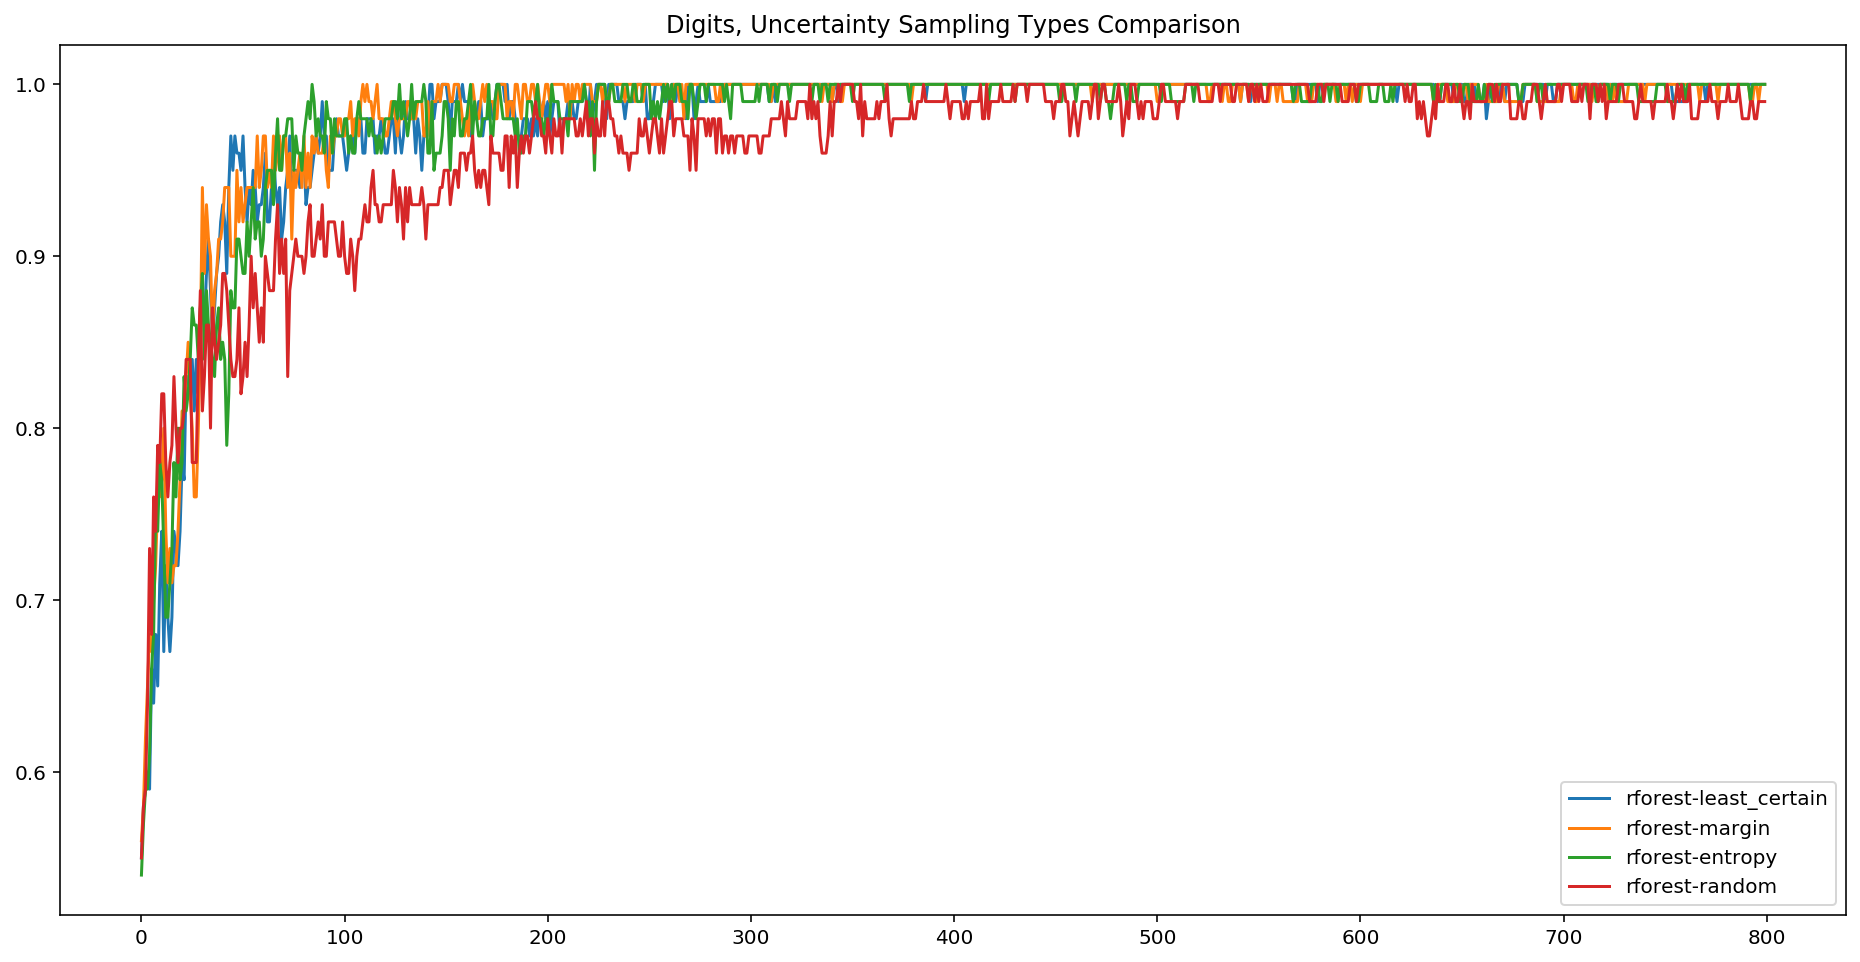

In [38]:
%%time

# load dataset
dataset = load_digits()
X = dataset.data
y = dataset.target

# run active sampling experiment 3
all_ =  run_exp3(X, y, uncertainty_sampling, 800, 20, 100)

# plot graph
plt.figure(figsize=(16,8))
for scores in all_:
    plt.plot(scores);
plt.legend(labels=['rforest-least_certain','rforest-margin', \
                   'rforest-entropy', 'rforest-random']);
plt.title('Digits, Uncertainty Sampling Types Comparison');